In [1]:
## import
import torch,torchvision
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
torch.manual_seed(12345)

In [2]:
lr=0.0002
z_dim=128
channels=3
img_size=64
batch_size=64
epochs=10

In [3]:
## 数据准备
from torch.utils.data import DataLoader
import os.path as osp
import glob
def make_datapath_list(root_path):
    """
    Returns:
    -----------
    path_list:list
    保存数据路径的列表
    """
    target_path=osp.join(root_path+'/**/*.jpg')
    
    #使用glob取得文件路径
    return glob.glob(target_path)

root_path='/kaggle/input/celeba'
l=make_datapath_list(root_path)

train_num=int(len(l)*0.8)
train_list=l[:train_num]
test_list=l[train_num:]
len(test_list)


40520

In [4]:
#创建Dataset
from torch.utils import data
import torchvision
from PIL import Image
class CelebDataset(data.Dataset):
    """
    file_path:list
    transform:object
    phase:'train' or 'val'
    """
    def __init__(self,file_list,transform=None,phase='train'):
        self.file_list=file_list
        self.transform=transform
        self.phase=phase
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,index):
        """
        获取预处理完毕的图片的张量数据和标签
        """
        img_path=self.file_list[index]
        img=Image.open(img_path)
        img_tranformed=self.transform(img)
        return img_tranformed
    
transform = transforms.Compose([
                               transforms.Resize((img_size,img_size)),
                               transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5, 0.5),(0.5, 0.5, 0.5))])
train_dataset=CelebDataset(file_list=train_list,transform=transform,phase='train')
test_dataset=CelebDataset(file_list=test_list,transform=transform,phase='test')

index=1
print(train_dataset.__getitem__(index))
print(train_dataset.__getitem__(index)[0].size())


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  0.9922,  0.9922,  0.9922],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.9922,  0.9922,  0.9922],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.9922,  0.9922,  0.9922],
         ...,
         [ 0.2863,  0.2157,  0.3490,  ...,  0.8902,  0.8980,  0.8980],
         [ 0.3490,  0.3333,  0.2863,  ...,  0.8745,  0.8824,  0.8902],
         [ 0.3569,  0.3176,  0.1451,  ...,  0.8824,  0.8824,  0.8902]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.0745, -0.1529, -0.0431,  ...,  0.7647,  0.7647,  0.7647],
         [-0.0353, -0.0588, -0.1373,  ...,  0.7333,  0.7490,  0.7569],
         [-0.0353, -0.0824, -0.2863,  ...,  0.7412,  0.7333,  0.7490]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  0.9529,  0.9529,  0.9529],
         [ 1.0000,  1.0000,  1.0000,  ...,  0

In [5]:
#创建DataLoader
train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,
                                             shuffle=True,drop_last=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,
                                            shuffle=False,drop_last=True)
dataloaders_dict={
    'train':train_dataloader,
    'test':test_dataloader
}

batch_iter=iter(dataloaders_dict['train'])#转成迭代器
inputs=next(batch_iter)#取第一个元素
print(inputs.size())


torch.Size([64, 3, 64, 64])


In [6]:
## 生成器
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        block1 = [
            nn.Linear(z_dim, 4 * 4 * 1024),
            nn.BatchNorm1d(4 * 4 * 1024),
            nn.ReLU()
        ]

        block2 = [
            nn.ConvTranspose2d(1024, 512, 4, 2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ]

        block3 = [
            nn.ConvTranspose2d(512, 256, 4, 2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ]

        block4 = [
            nn.ConvTranspose2d(256, 128, 4, 2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ]

        block5 = [
            nn.ConvTranspose2d(128,channels, 4, 2, padding=1),
            nn.Tanh()            
        ]

        all_blocks = block2 + block3 + block4 + block5
        self.main1 = nn.Sequential(*block1)
        self.main2 = nn.Sequential(*all_blocks)

        # Free some memory
        del all_blocks, block1, block2, block3, block4, block5



    def forward(self, x):
        for layer in self.main1:
            x = layer(x)
        x = x.view(-1, 1024, 4, 4)  # Reshape for convolution
        for layer in self.main2:
            x = layer(x)
        return x
noise=torch.randn((batch_size,z_dim))
g=Generator()
imgs=g(noise)
imgs.shape

torch.Size([64, 3, 64, 64])

In [7]:
## 判别器
class Discriminator(nn.Module):
    """
    Down scaling by a factor of 2
        combination #1
        k = 6 | s = 2 | p = 2
        combination #2 --- Best for me!
        k = 4 | s = 2 | p = 1
        combination #3 (s = 1.333)
        k = 4 | s = 1 | p = 0
        combination #4 (p = 1.5)
        k = 5 | s = 2 | p = 1
    """

    def __init__(self):
        super(Discriminator, self).__init__()

        block1 = [
            nn.Conv2d(channels, 64, 4, 2, padding=1, bias=False),
            nn.LeakyReLU(0.2)
        ]

        block2 = [
            nn.Conv2d(64, 128, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        ]

        block3 = [
            nn.Conv2d(128, 256, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        ]

        block4 = [
            nn.Conv2d(256, 512, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Flatten()
        ]
        
        all_blocks = block1 + block2 + block3 + block4
        self.conv = nn.Sequential(*all_blocks)
        self.linear = nn.Linear(4 * 4 * 512, 1, bias=False)

        # Free some memory
        del all_blocks, block1, block2, block3, block4

    def forward(self, x):
        for layer in self.conv:
            x = layer(x)
        #x = x.view(-1, self.num_flat_features(x))  # flatten the conv output
        x = self.linear(x)
        return x
d=Discriminator()
d(imgs).shape

torch.Size([64, 1])

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create models
G= Generator().to(device)
D = Discriminator().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(G.parameters(), 2e-4, betas=(0.5, 0.999))
optimizer_D= torch.optim.Adam(D.parameters(), 2e-4, betas=(0.5, 0.999))

In [9]:
cuda=True if torch.cuda.is_available() else False
FloatTensor=torch.cuda.FloatTensor if cuda else torch.Tensor
fixed_z=torch.randn((batch_size,z_dim)).to(device)
G_trains=1
D_trains=2
num_batchs=100000
NORM='l2'
def show(imgs,figsize=(6,6)):
    plt.figure(figsize=figsize)
    imgs=torchvision.utils.make_grid(imgs,nrow=10,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.show()

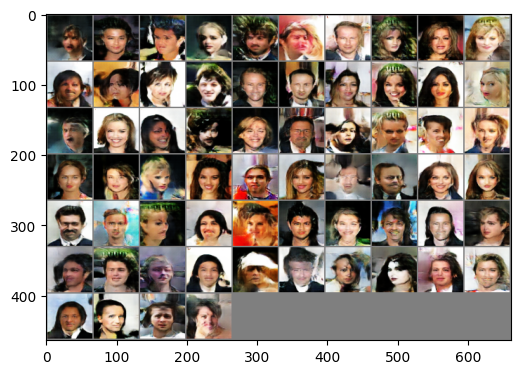

iter: 11101, d_loss: -3.556698799133301, g_loss: 8.545461654663086
iter: 11102, d_loss: -3.99527645111084, g_loss: 8.314361572265625
iter: 11103, d_loss: -3.5145153999328613, g_loss: 9.569371223449707
iter: 11104, d_loss: -3.5686373710632324, g_loss: 7.34419059753418
iter: 11105, d_loss: -3.9955272674560547, g_loss: 6.481871604919434
iter: 11106, d_loss: -3.8706836700439453, g_loss: 6.278536319732666
iter: 11107, d_loss: -3.1198930740356445, g_loss: 8.122739791870117
iter: 11108, d_loss: -3.8310647010803223, g_loss: 9.408074378967285
iter: 11109, d_loss: -3.7398157119750977, g_loss: 8.818588256835938
iter: 11110, d_loss: -3.95974063873291, g_loss: 9.371939659118652
iter: 11111, d_loss: -3.7144510746002197, g_loss: 6.616950035095215
iter: 11112, d_loss: -3.9400157928466797, g_loss: 10.073254585266113


KeyboardInterrupt: 

In [18]:
from IPython.display import clear_output
def get_infinite_data(dataloader):
        while True:
            for images in dataloader:
                yield images
train_generator=get_infinite_data(train_dataloader)
def get_batch():
    return train_generator.__next__().to(device)

for i in range(num_batchs):
    #训练判别器
    for param in G.parameters():
        param.requires_grad_(False)
    for param in D.parameters():
        param.requires_grad_(True)
    for _ in range(D_trains):
        x_real=get_batch()
        z_sample=torch.randn((batch_size,z_dim)).to(device)
        x_fake=G(z_sample)
        x_real_score=D(x_real)
        x_fake_score=D(x_fake.detach())
        
        optimizer_D.zero_grad()
        d_loss=x_real_score-x_fake_score
        if NORM=='l1':
            d_norm=10*(x_real-x_fake).abs().mean()
        elif NORM=='l2':
            d_norm=10*((x_real-x_fake)**2).mean().sqrt()
        d_loss=-d_loss+0.5*d_loss**2/d_norm
        d_loss=d_loss.mean()
        
        d_loss.backward()
        optimizer_D.step()
    
    #训练生成器
    for param in G.parameters():
        param.requires_grad_(True)
    for param in D.parameters():
        param.requires_grad_(False)
    for _ in range(G_trains):
        x_real=get_batch()
        z_sample=torch.randn((batch_size,z_dim)).to(device)
        x_fake=G(z_sample)
        x_real_score=D(x_real)
        x_fake_score=D(x_fake)
        
        optimizer_G.zero_grad()
        g_loss=x_real_score-x_fake_score
        g_loss=g_loss.mean()
        
        g_loss.backward()
        optimizer_G.step()
        print(f"iter: {i}, d_loss: {d_loss}, g_loss: {g_loss}")
    if i%100==0:
        print(f'iter:{i}')
        clear_output()
        with torch.no_grad():
            x_fake=G(fixed_z)
        show(x_fake)
        
    
        

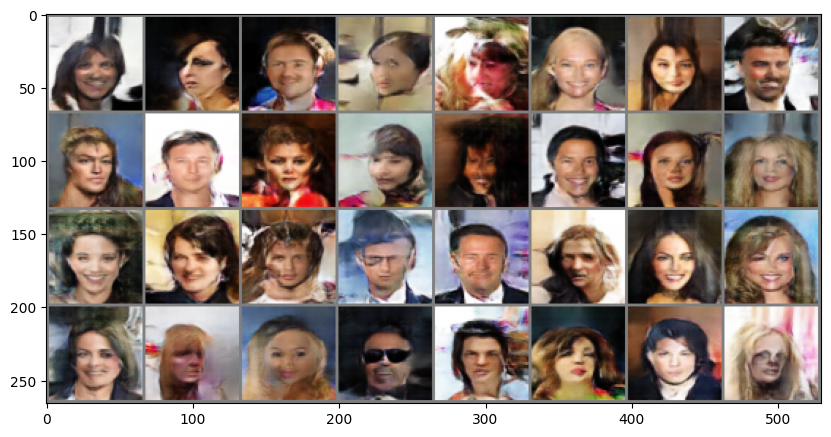

In [78]:
def show_k_images(k,imgs=None,name='faces.png'):
    plt.figure(figsize=(10,10))
    if imgs==None:
        z=torch.rand((k,z_dim)).to(device)
        imgs=G(z)
    imgs=torchvision.utils.make_grid(imgs,nrow=8,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.savefig(name)
    plt.show()
def show_pair_image(img1,img2):
    plt.figure(figsize=(8,8))
    imgs=torch.cat([img1.unsqueeze(0),img2.unsqueeze(0)],dim=0)
    imgs=torchvision.utils.make_grid(imgs,nrow=2,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.show()
    plt.savefig('faces_8.png')
show_k_images(32,None,'faces_32.png')

In [58]:
temp_list=l[:1000]
temp_dataset=CelebDataset(file_list=temp_list,transform=transform,phase='test')
temp_dataloader=torch.utils.data.DataLoader(temp_dataset,batch_size=1,shuffle=True)

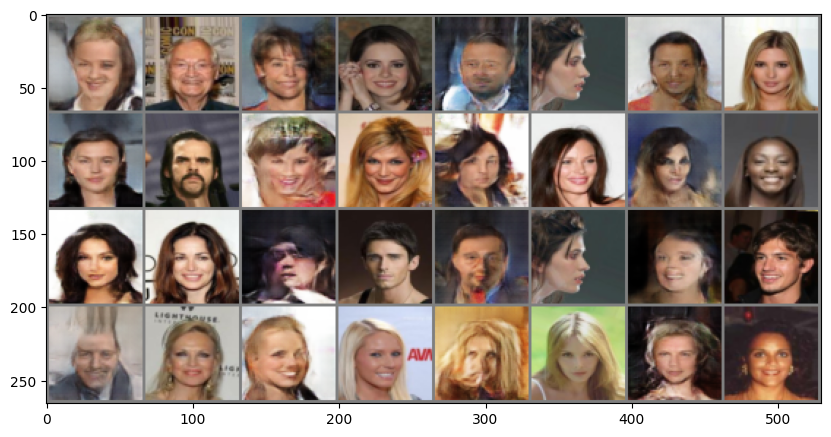

In [82]:
def get_similar_face_pair(img):
    similar_img=min(temp_dataloader,key=lambda x: ((x-img)**2).mean())
    pair_img=torch.cat([img.unsqueeze(0),similar_img],dim=0)
    return pair_img

n_to_show=16
z=torch.rand((n_to_show,z_dim)).to(device)
fake_imgs=G(z)
fake_imgs=fake_imgs.to('cpu')
tp_list=[]
for i in range(n_to_show):
    tp_list.append(get_similar_face_pair(fake_imgs[i]))
imgs=torch.cat(tp_list,dim=0)
show_k_images(n_to_show*2,imgs,'compare_Fake_Real.png')